In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [5]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []

for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-03-13 13:31:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-03-13 13:31:13 (114 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [6]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [7]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 26s 2ms/sample - loss: 6.9058 - acc: 0.0205
Epoch 2/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.5046 - acc: 0.0210
Epoch 3/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.3950 - acc: 0.0240
Epoch 4/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.2653 - acc: 0.0295
Epoch 5/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.1733 - acc: 0.0351
Epoch 6/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.0888 - acc: 0.0380
Epoch 7/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.0057 - acc: 0.0404
Epoch 8/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 5.9270 - acc: 0.0440
Epoch 9/100
15462/15462 [==============================] - 

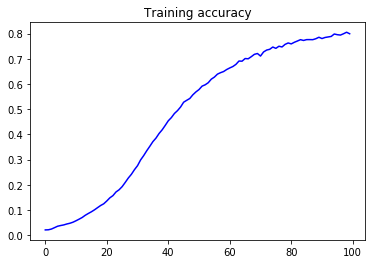

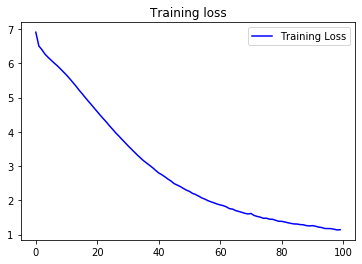

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [9]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope or my heart's graces dead eye hate hate out of hate hate doth pride another heart not young that new eye before well spent pride weeds go speaking of light light light light spent words aside privilege heaven mistaking slain bow bow bow light grow sad treasure time's part quite ward ward brought ground ground hate light spent owe bow cross'd hate skill ' said be bevel remain thought hate ' live for store in this quite asleep dearth dead grow sad treasure heaven lie on thy part kind kind there hate still seem long one untrue young to me
